
<span > <h1 style="color:blue">Modelado Analitica de Texto: Arboles de desición</h1></span>

A continuación se va a presentar un modelo de clasificación usando arboles de desición de manera que se pueda predecir si una reseña podría llegar a ser positiva o negativa. Cabe resaltar que el perfilamiento y el analisis se encuentra en mayor detalle en el notebook con el nombre  Modelado_analitica_texto en la carpte Etapa 1.

## 1.Cargar librerías

In [2]:
import nltk
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

import re, string, unicodedata
from num2words import num2words
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

C:\Users\El supremo\AppData\Local\Temp\ipykernel_14096\2444124493.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
[nltk_data] Downloading package punkt to C:\Users\El
[nltk_data]     supremo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Cargar Datos y limpieza 
La explicación de la limpiea se encuentra en el otro notebook.

In [3]:
df_rp = pd.read_csv('./PeliculasRevisiones/MovieReviews.csv', sep=',', encoding = 'utf-8')
df_rp.sample(5)


,Unnamed: 0,review_es,sentimiento
3493,3493,"Lo siento por Jean, después de tener una pelíc...",negativo
1063,1063,Me encanta la pelicula.Me trajo de vuelta al m...,positivo
4817,4817,Estoy trabajando a través de la colección de P...,negativo
4468,4468,"LESLIE SANDS 'PLAY PLAY PLAY ""MODERNO"" se conv...",negativo
3412,3412,Un relato escalofriante y sangriento de una pa...,negativo


In [4]:
df_transform = df_rp.copy()
df_transform=df_transform.drop_duplicates(subset=['review_es'])

In [5]:


 def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [x.lower() for x in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = num2words(word, lang = 'es_CO')
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stopword_es = nltk.corpus.stopwords.words('spanish')
    new_words = []

    for word  in words:
        if word not in stopword_es:
            new_words.append(word)
    return new_words
    
def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words


In [6]:
df_transform['words'] = df_transform['review_es'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df_transform['words'] = df_transform['words'].apply(lambda x: ' '.join(map(str, x)))
df_transform['words'] = df_transform['words'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df_transform['words'] = df_transform['words'].apply(lambda x: ' '.join(map(str, x)))


## 2.1. Matriz 

In [7]:
 X_data, y_data = df_transform['words'],df_transform['sentimiento']
y_data = (y_data == 'negativo').astype(int)
y_data

0       0
1       0
2       0
3       0
4       0
       ..
4995    1
4996    1
4997    1
4998    1
4999    1
Name: sentimiento, Length: 4998, dtype: int32

In [8]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)
print(X_dummy.shape)
X_dummy.toarray()[0]


(4998, 56099)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
nombre_caracteristica = dummy.get_feature_names()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3. Modelo con Arboles de desición:

### 3.1. Variable objetivo

In [10]:
import seaborn as sns; sns.set()


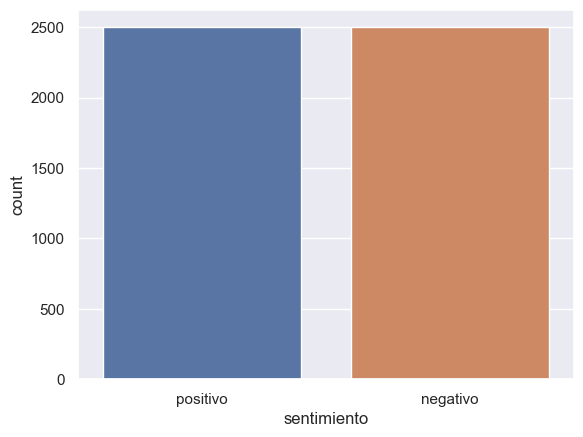

In [11]:
ax = sns.countplot(x='sentimiento', data=df_transform)

### 3.2. Modelo 1:  Min samples 2 & default depth

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, y_data, test_size=0.2, random_state=0)
arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)
tree = arbol.fit(X_train,Y_train)
y_pred = tree.predict(X_test)
confusion_matrix(Y_test, y_pred)

array([[364, 134],
       [175, 327]], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


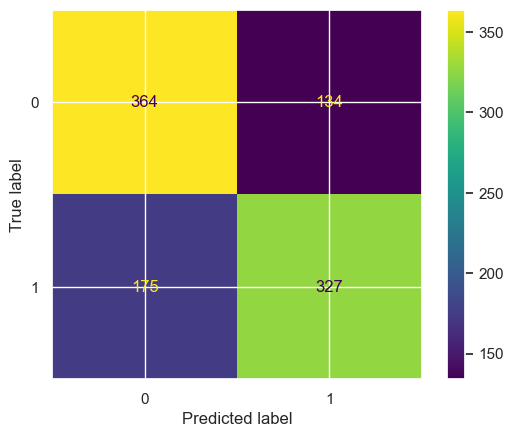

In [13]:
plot_confusion_matrix(arbol, X_test, Y_test)  


In [14]:
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.73      0.70       498
           1       0.71      0.65      0.68       502

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


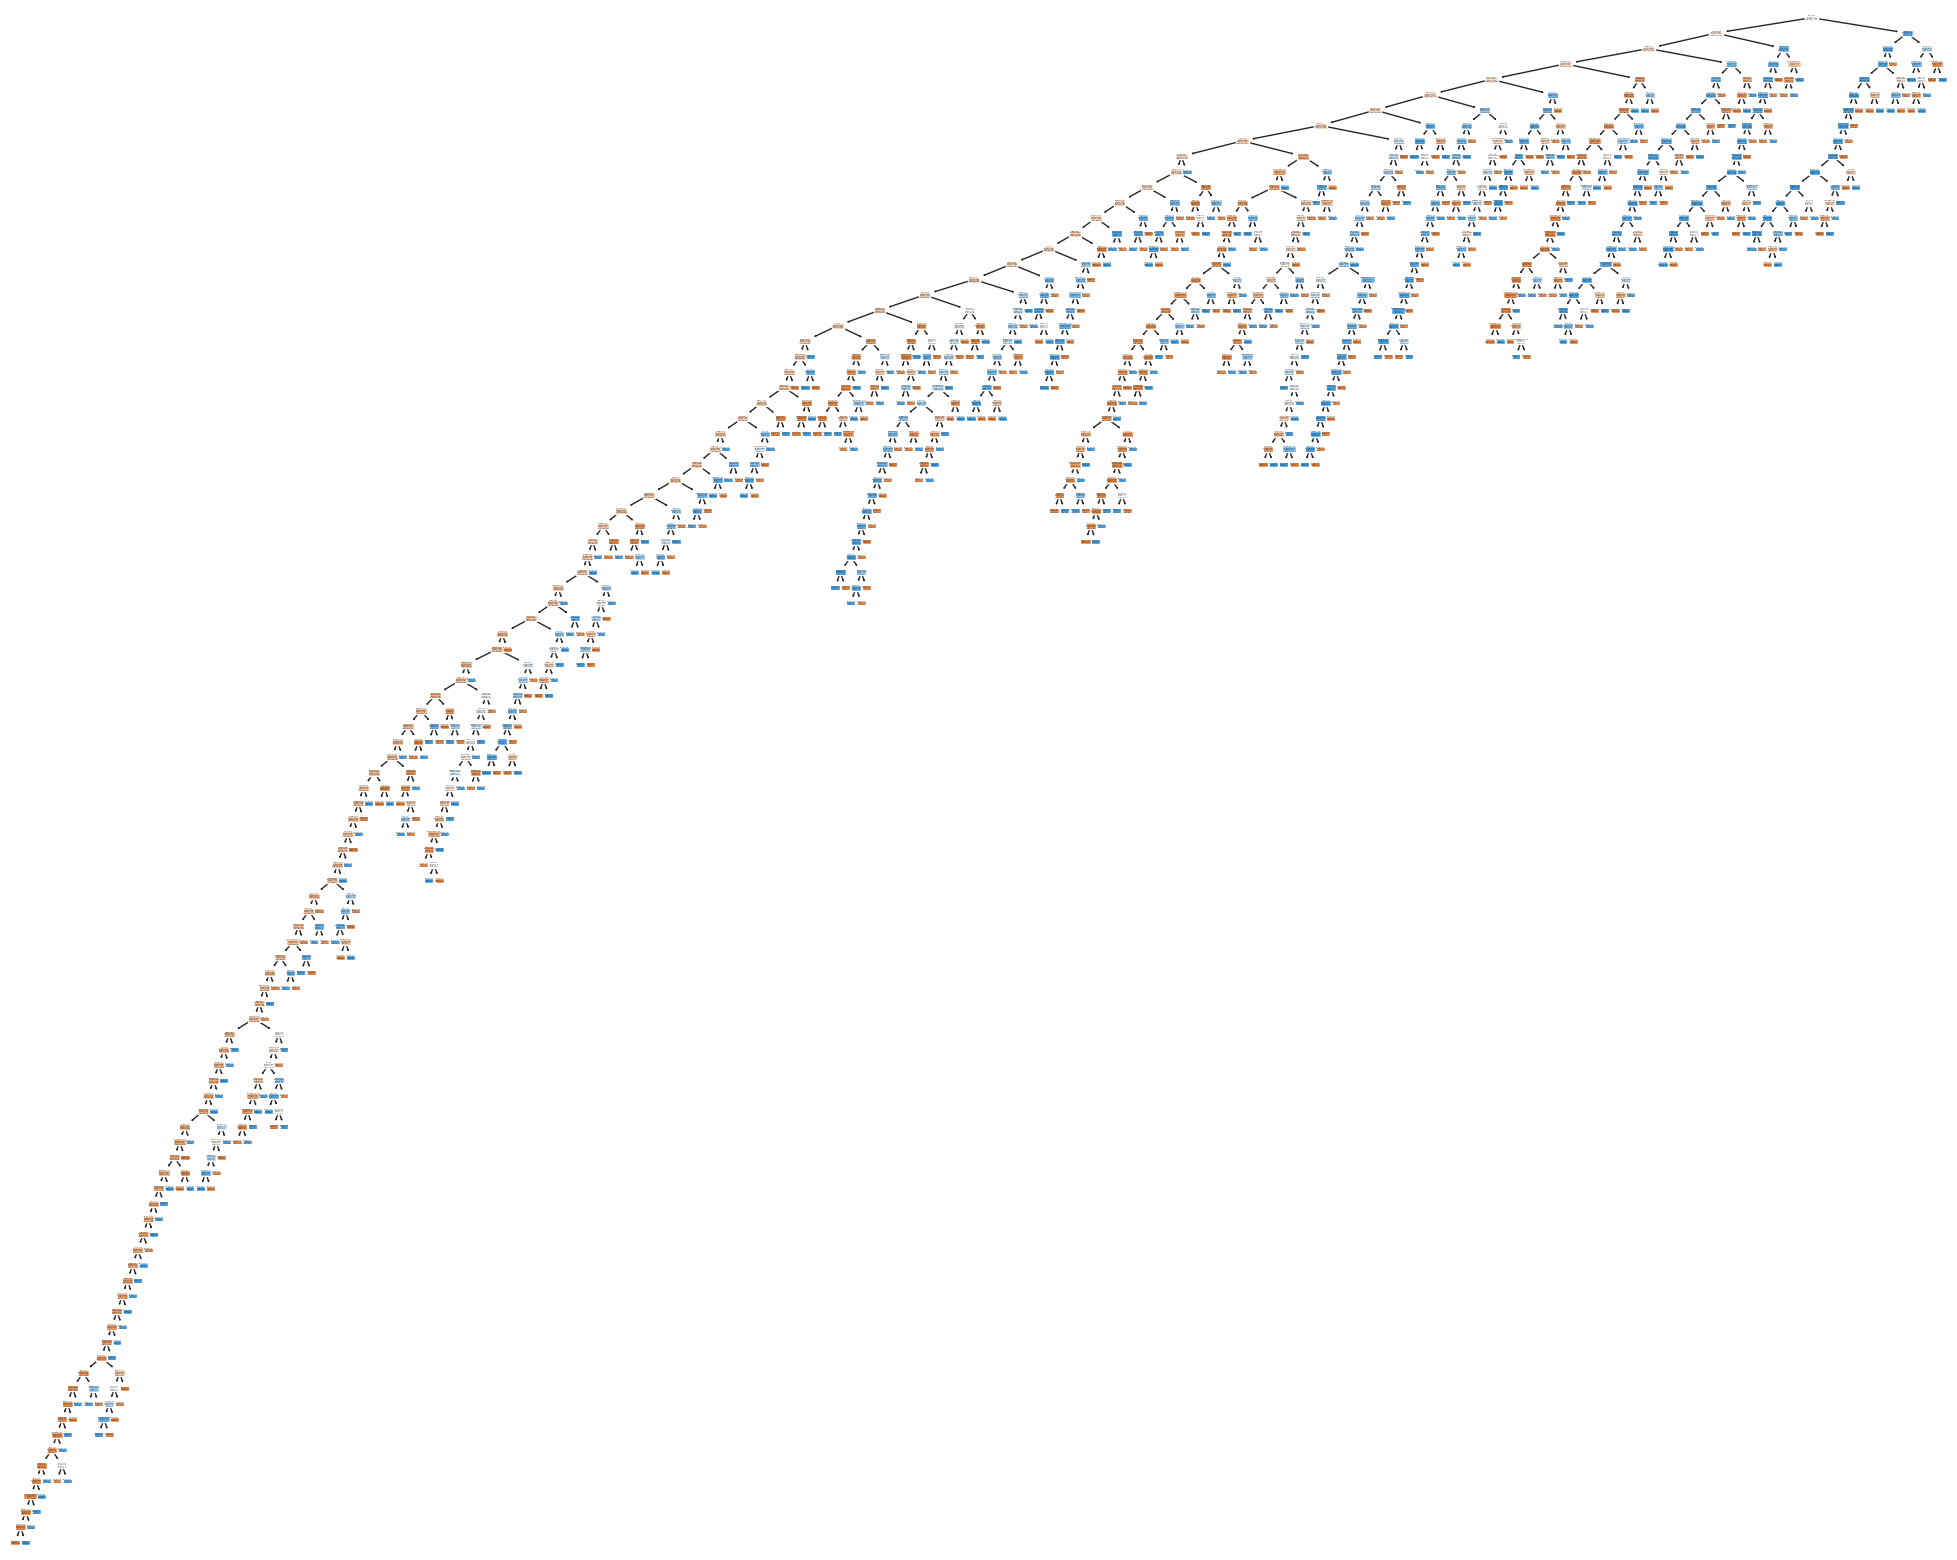

In [20]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=dummy.get_feature_names(), filled=True)

In [29]:
precision = accuracy_score(Y_test, y_pred)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.691


### 3.3 Model 2: Best tree

In [16]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV


particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[20,22,24,26,28],'min_samples_split':[2,3,4,5,6,7,8,9,10]}
tree = DecisionTreeClassifier(random_state=0)
best_model = GridSearchCV(tree, param_grid, cv=particiones)
best_model.fit(X_train, Y_train)
print(best_model.best_params_)

{'criterion': 'entropy', 'max_depth': 28, 'min_samples_split': 4}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


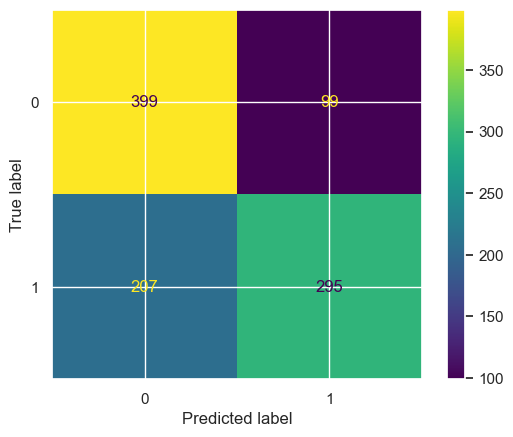

In [17]:
import matplotlib.pyplot as plt

best_tree = best_model.best_estimator_
y_pred_train = best_tree.predict(X_train)
y_pred_test = best_tree.predict(X_test)
plot_confusion_matrix(best_tree, X_test, Y_test)  
plt.show()

In [21]:
print(classification_report(Y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.66      0.80      0.72       498
           1       0.75      0.59      0.66       502

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


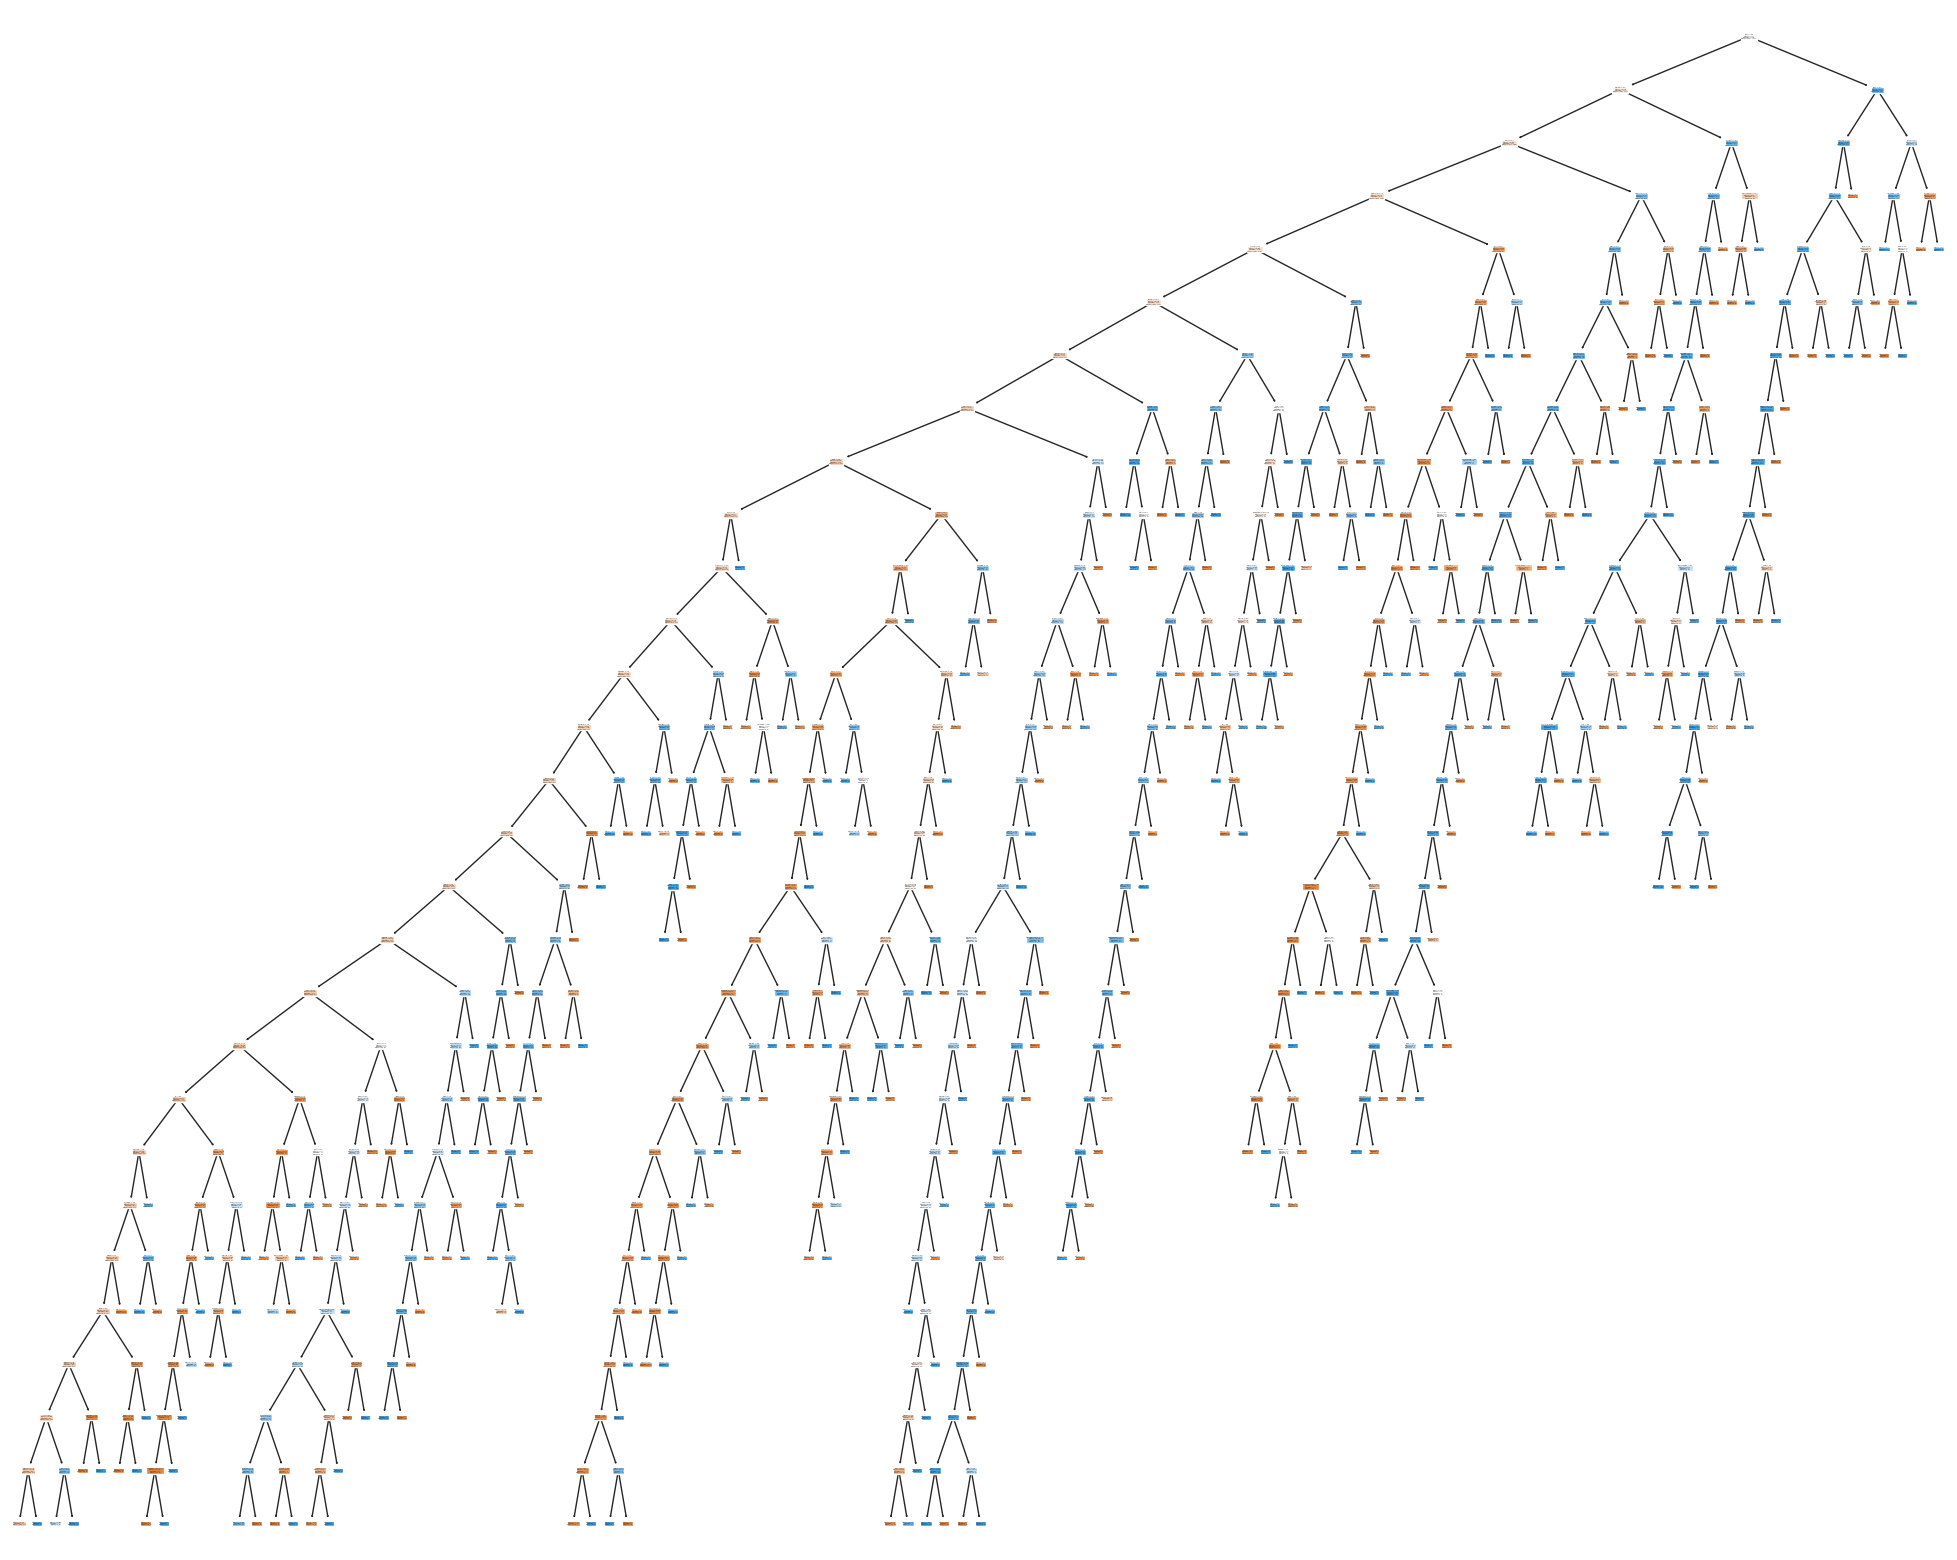

In [22]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_tree, feature_names=dummy.get_feature_names(), filled=True)

In [28]:
precision = accuracy_score(Y_test, y_pred_test)

print("Precisión del modelo:", precision)


Precisión del modelo: 0.694


### 3.4 Model 3: Tree with no parameters

In [23]:
modelo = DecisionTreeClassifier()
modelo.fit(X_train, Y_train)


DecisionTreeClassifier()

In [24]:
predicciones = modelo.predict(X_test)
precision = accuracy_score(Y_test, predicciones)
print("Precisión del modelo:", precision)


Precisión del modelo: 0.699


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


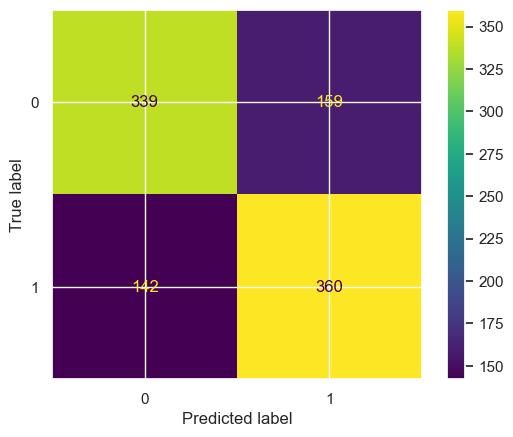

In [25]:
plot_confusion_matrix(modelo, X_test, Y_test)  


In [27]:
print(classification_report(Y_test, predicciones))


              precision    recall  f1-score   support

           0       0.70      0.68      0.69       498
           1       0.69      0.72      0.71       502

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo, feature_names=dummy.get_feature_names(), filled=True)

### 4. Conclusiones

En general se puede ver que la presión está en un valor cercano al 69%, lo cual no es muy bueno. Esto ocurre en casi todos los modelos presentados anteriormente. En base a las metricas de los diferentes modelos se puede decir que los mojores modelos van en el siguiente orden:

1. Modelo 3 con una presición del 0.699
2. Modelo 2 con una presición con el 0.694
3. Modelo 1 con una presición con un 0.691

